# Proyek Klasifikasi Gambar: [Input Nama Dataset]
- **Nama:** -
- **Email:** -
- **ID Dicoding:** -

## Import Semua Packages/Library yang Digunakan

In [16]:
import zipfile
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
import os
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
from keras import Input
from pathlib import Path
import tensorflowjs as tfjs
warnings.simplefilter(action='ignore', category=FutureWarning)
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [4]:
from google.colab import files
files.upload()

# Create kaggle folder and move file
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json

# Set permissions
!chmod 600 /root/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d ash2703/handsignimages -p .
local_zip = 'handsignimages.zip'
with zipfile.ZipFile(local_zip, 'r') as zip_ref:
    zip_ref.extractall('handsign')  # Extracts into 'handsign/' folder

Dataset URL: https://www.kaggle.com/datasets/ash2703/handsignimages
License(s): DbCL-1.0
  0% 0.00/23.1M [00:00<?, ?B/s]
100% 23.1M/23.1M [00:00<00:00, 1.12GB/s]


In [6]:
combined_dir = "handsign/dataset"
train_dir = "handsign/Train"
test_dir = "handsign/Test"

os.makedirs(combined_dir, exist_ok=True)
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)
shutil.rmtree('handsign/Train')
shutil.rmtree('handsign/Test')

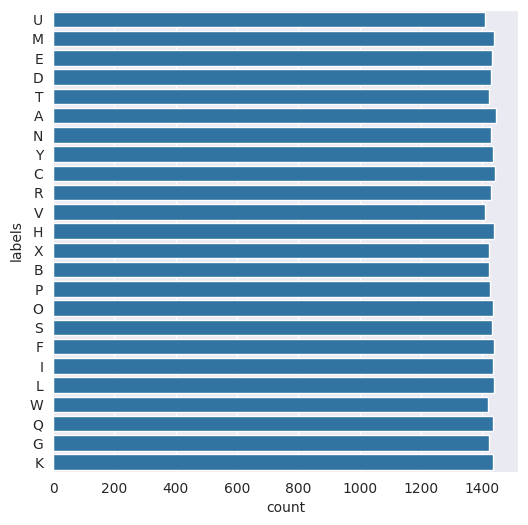

In [17]:
dataset_path = "handsign/dataset/"
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(Path(path)/name)
        labels.append(path.split('/')[-1])
        file_name.append(name)
df = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})


Label = df['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [18]:
X= df['path']
y= df['labels']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)

In [19]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_val = pd.DataFrame({'path':X_val,'labels':y_val,'set':'val'})
df_n = pd.concat([df_tr, df_te, df_val])
datasource_path = "handsign/dataset/"
dataset_path = "handsign/"

In [20]:
for index, row in df_n.iterrows():
    file_path = row['path']
    if not os.path.exists(file_path):
            file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])

    if not os.path.exists(os.path.join(dataset_path, row['set'], row['labels'])):
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    destination_file_name = file_path.name
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    if not os.path.exists(file_dest):
        shutil.copy2(file_path,file_dest)

## Modelling

In [21]:
train_dir = "handsign/train"
test_dir = "handsign/test"
val_dir = "handsign/val"
datagen = ImageDataGenerator(rescale=1/255.)
validation_datagen = ImageDataGenerator(rescale=1. / 255)
test_datagen = ImageDataGenerator(rescale=1. / 255)
train_generator = datagen.flow_from_directory(train_dir,
                                              batch_size=32,
                                              target_size=(28, 28),
                                              color_mode="grayscale",
                                               class_mode='categorical',
                                              shuffle=True)

validation_generator = validation_datagen.flow_from_directory(val_dir,
                                                   batch_size=32,
                                                  target_size=(28, 28),
                                                   color_mode="grayscale",
                                                   class_mode='categorical',
                                                   shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                                  batch_size=1,
                                                  target_size=(28, 28),
                                                  color_mode="grayscale",
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 24030 images belonging to 24 classes.
Found 5149 images belonging to 24 classes.
Found 5150 images belonging to 24 classes.


In [22]:
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(32, (3,3),padding='same', activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3),padding='same', activation='relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3),padding='same', activation='relu'),
    MaxPooling2D((2,2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dense(24, activation='softmax')
])
model.compile(optimizer=keras.optimizers.RMSprop(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 243,352 (950.59 KB)

 Trainable params: 243,352 (950.59 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
callbacks = [
     ReduceLROnPlateau(
            monitor='val_loss', factor=0.5, patience=2, verbose=1)
]
history = model.fit(
    train_generator,
    epochs=30,
    batch_size=32,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


751/751 ━━━━━━━━━━━━━━━━━━━━ 49s 63ms/step - accuracy: 0.4443 - loss: 1.8442 - val_accuracy: 0.9763 - val_loss: 0.0816 - learning_rate: 0.0010
Epoch 2/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 46s 61ms/step - accuracy: 0.9781 - loss: 0.0755 - val_accuracy: 0.9992 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 3/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 49s 65ms/step - accuracy: 0.9947 - loss: 0.0222 - val_accuracy: 0.9988 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 4/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 47s 63ms/step - accuracy: 0.9990 - loss: 0.0052 - val_accuracy: 1.0000 - val_loss: 3.1433e-04 - learning_rate: 0.0010
Epoch 5/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 47s 62ms/step - accuracy: 0.9995 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 9.4528e-06 - learning_rate: 0.0010
Epoch 6/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 48s 64ms/step - accuracy: 1.0000 - loss: 4.3972e-06 - val_accuracy: 1.0000 - val_loss: 5.3330e-06 - learning_rate: 0.0010
Epoch 7/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 1.0000

## Evaluasi dan Visualisasi

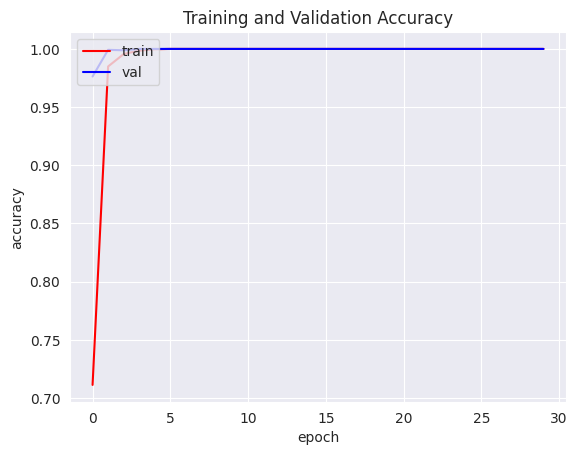

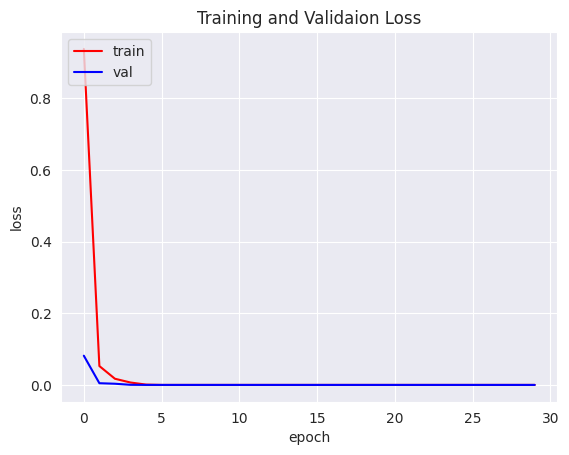

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

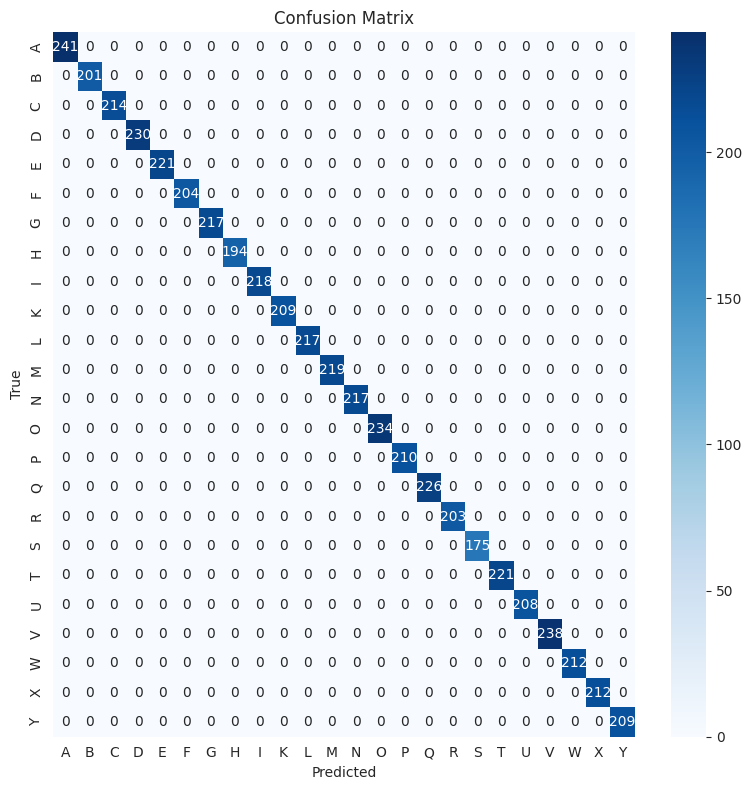

              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000       241
           B     1.0000    1.0000    1.0000       201
           C     1.0000    1.0000    1.0000       214
           D     1.0000    1.0000    1.0000       230
           E     1.0000    1.0000    1.0000       221
           F     1.0000    1.0000    1.0000       204
           G     1.0000    1.0000    1.0000       217
           H     1.0000    1.0000    1.0000       194
           I     1.0000    1.0000    1.0000       218
           K     1.0000    1.0000    1.0000       209
           L     1.0000    1.0000    1.0000       217
           M     1.0000    1.0000    1.0000       219
           N     1.0000    1.0000    1.0000       217
           O     1.0000    1.0000    1.0000       234
           P     1.0000    1.0000    1.0000       210
           Q     1.0000    1.0000    1.0000       226
           R     1.0000    1.0000    1.0000       203
           S     1.0000    

In [25]:
test_generator.reset()
pred = model.predict(test_generator,verbose=0)
pred = pred.copy()

pred_classes = np.argmax(pred, axis=1)
true_classes = test_generator.classes

class_indices = test_generator.class_indices
class_names = {v:k for k,v in class_indices.items()}

labels = [class_names[i] for i in range(len(class_names))]
cm = confusion_matrix(true_classes, pred_classes)

plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
print(classification_report(
    y_true=true_classes,
    y_pred=pred_classes,
    target_names=labels,
    digits=4))

## Konversi Model

In [31]:
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

tfjs.converters.save_keras_model(model, "tfjs_model")

converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

model_dir = pathlib.Path('tflite')
model_dir.mkdir(parents=True, exist_ok=True)

label_file_path = pathlib.Path('tflite/labels.txt')
label_file_path.write_text('\n'.join(labels))

tflite_model_file = model_dir / 'model.tflite'
tflite_model_file.write_bytes(tflite_model)

failed to lookup keras version from the file,
    this is likely a weight only file


8464

## Inference (Optional)